## Premier challenge

#### Import libraries

In [322]:
%matplotlib inline
import os
from atreyu import compare_dists
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scp
import numpy as np
import random as rd
import seaborn as sns
from Tools import *

#### Loading observed data


In [395]:
df = pd.read_csv("./datachallenge1", header = None)
observed_data = df[0]
n = len(df)

The parameters fixed are :\
The initial population size : $N_{initial}$\
The final population size : $N_{final}$\
Death rate : $\tau_{death}$\
No effect on fitness: $f = 1$\
Sampling step : $p=1$

In [324]:
n_initial = 10
n_final = 1e7
death_rate = 0.3
fitness = 1
param = 1
seed = 1

#### Values of $\mu$ :

Let $\mu_{reel}$ the unkown mutation rate.
We want to estimate this value used to generate the observed data $ x = (x_1, ... , x_n)$ where $x_i$ is number of mutant in the population, $n = 384 $ is size of given sample.

To do this, we are going to choose a value that we calculate using the mean of given data :

$$ \mu_0 = \frac{\bar x_n}{n_{final}} $$

We will be using different priors to generate our values of $\mu$, and will be comparing their results. The followings priors will be used :

-A uniform distribution such that: $$\mu \sim \mathcal{U}(10^{-8}, 10^{-6})$$

-A reciprocal distribution such that: $$log(\mu) \sim \mathcal{U}(log(10^{-6}), log(10^{-8}))$$

-A gamma distribution such that: $$\mu \sim \gamma(\alpha, \beta)$$

-A log-normal distribution such that: $$log(\mu) \sim \mathcal{N}(log(10^{-7}), 0.5)$$

such that : $\alpha = \frac{\tilde{x}^{2}}{IQR^2}$ and $\beta = \frac{\tilde{x}}{IQR^2}$ with $\tilde{x}$ the median of $x$ and $IQR$ its interquantile range.

In [326]:
np.random.seed(42)
mu_zero = observed_data.mean()/n_final
# number of generated values of mu
n_mu = 500
# number of simulations
n_sample = 500
# we are looking for positive values

# Generate samples from the uniform distribution
mu_values_uniform = np.random.uniform(1e-8, 1e-6, size=n_mu)
# Generate samples from the reciprocal distribution
mu_values_reciprocal = scp.loguniform.rvs(1e-8, 1e-6, size=n_mu)
# Generate samples from the Gamma distribution
alpha = 81
beta = 1.11e-9
mu_values_gamma = np.random.gamma(alpha, beta, size = n_mu)

# Generate samples from the log-normal distribution
log_mu_values = np.random.normal(-16, 0.5, size=n_mu)

# Convert the samples to mutation rates
mu_values_normal = np.exp(log_mu_values)

Let's visualize and compare the generated values of $\mu$ by the different priors by drawing the log-scaled histogram.

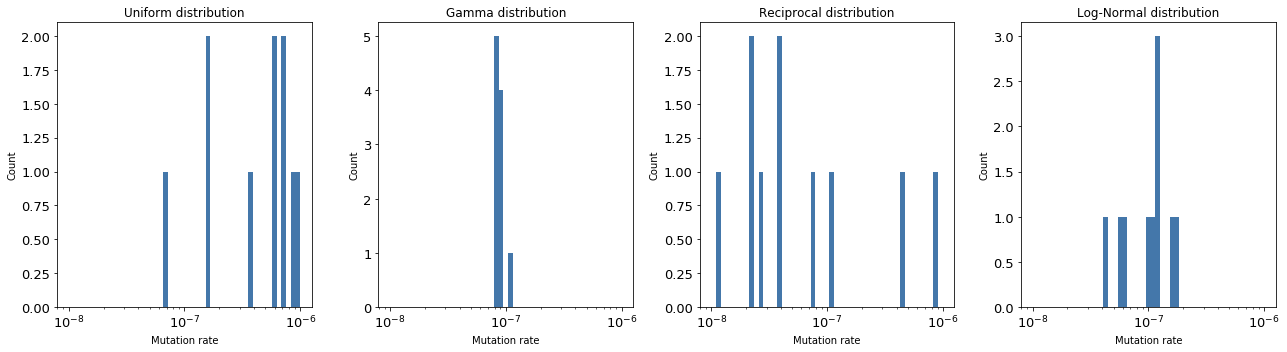

In [327]:
# Define the bins for the histograms
bins = np.logspace(start=-8, stop=-6, num=50)

# Plot the histograms side by side
fig, axs = plt.subplots(1, 4, figsize=(18, 5))

axs[0].hist(mu_values_uniform, bins=bins)
axs[0].set_xscale('log')
axs[0].set_xlabel('Mutation rate')
axs[0].set_ylabel('Count')
axs[0].set_title('Uniform distribution')

axs[1].hist(mu_values_gamma, bins=bins)
axs[1].set_xscale('log')
axs[1].set_xlabel('Mutation rate')
axs[1].set_ylabel('Count')
axs[1].set_title('Gamma distribution')

axs[2].hist(mu_values_reciprocal, bins=bins)
axs[2].set_xscale('log')
axs[2].set_xlabel('Mutation rate')
axs[2].set_ylabel('Count')
axs[2].set_title('Reciprocal distribution')

axs[3].hist(mu_values_normal, bins=bins)
axs[3].set_xscale('log')
axs[3].set_xlabel('Mutation rate')
axs[3].set_ylabel('Count')
axs[3].set_title('Log-Normal distribution')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.2)

# Show the plot
plt.show()

As can be noticed, the uniform distribution does not generate values that are uniformly centered around $10^{-7}$
on a logarithmic scale. Which justifies the use for both the others distributions that are logarithmically scaled.
The advantage of the Gamma distribution is that it does not exclude values outside of the interval, but only makes
their generation much less likely, which could also be a disadvantage in case it generates values of $\mu$ that are
too big to be simulated in reasonable times.
The Normal distribution allows for the same thing while offering values that are much less centered around $10^{-7}$

Let's test all of these priors.

We are going to generate distributions using the values generated above and keep these samples in a data frame indexed by $\mu$ used to simulate.

#### Sampling

In [328]:
# a data frame containig the different results of simulation
generated_df_uniform = simulate(mu_values_uniform, n_initial,n_final,death_rate,fitness,param,n_sample)
generated_df_reciprocal = simulate(mu_values_reciprocal, n_initial,n_final,death_rate,fitness,param,n_sample)
generated_df_gamma = simulate(mu_values_gamma, n_initial,n_final,death_rate,fitness,param,n_sample)
generated_df_normal = simulate(mu_values_normal, n_initial,n_final,death_rate,fitness,param,n_sample)

#### Choose the best value of $\mu$  :

To choose the best value of $\mu$ among the generated values, we are going to use two different non-parametric test, Mann–Whitney U test and Kolmogorov–Smirnov test.
Let $F$ the cumulative distribution functions of the given sample. 
It consists on test-hypothesis with :

- Null hypothesis $H_0$ : The two distributions have the same cumulative distibution functions $G(u) = F(u)$ .
- Alternative hyppthesis $H_1$ : The two distrubitions are have differents cumulative distribution functions $G(u) \neq F(u)$

We decide that a confidence level of 95% is required to reject the null hypothesis in favor of the alternative that the distributions are different. The functions that we defined above will return the associated $\mu$ for the distribution with the maximum p-value greater than $0.05$ associated to the alternative hypothesis $H_1$ among the simulated samples. 



##### -  Mann–Whitney U test

In [329]:


# Uniform distribution
mu_mwt_uniform, p_value_mwt_uniform = mann_whiteney_test(generated_df_uniform,observed_data)
print("For a uniform distribution :\n\n")
print("The best value of mutation rate using Mann–Whitney U test is " + str(mu_mwt_uniform.idxmax()))
print("Its corresponding p value is " + str(p_value_mwt_uniform))

print("The 95% confidence interval for mutation rate is :")
print(scp.t.interval(confidence=0.95, df=len(mu_mwt_uniform.index)-1, loc=np.mean(mu_mwt_uniform.index),
                    scale=scp.sem(mu_mwt_uniform.index)))

# Reciprocal distribution
mu_mwt_reciprocal, p_value_mwt_reciprocal = mann_whiteney_test(generated_df_reciprocal,observed_data)
print("\n\nFor a reciprocal distribution :\n\n")
print("The best value of mutation rate using Mann–Whitney U test is " + str(mu_mwt_reciprocal.idxmax()))
print("Its corresponding p value is " + str(p_value_mwt_reciprocal))

print("The 95% confidence interval for mutation rate is :")
print(scp.t.interval(confidence=0.95, df=len(mu_mwt_reciprocal.index)-1, loc=np.mean(mu_mwt_reciprocal.index),
                    scale=scp.sem(mu_mwt_reciprocal.index)))

# Gamma distribution
mu_mwt_gamma, p_value_mwt_gamma = mann_whiteney_test(generated_df_gamma,observed_data)
print("\n\nFor a Gamma distribution :\n\n")
print("The best value of mutation rate using Mann–Whitney U test is " + str(mu_mwt_gamma.idxmax()))
print("Its corresponding p value is " + str(p_value_mwt_gamma))

print("The 95% confidence interval for mutation rate is :")
print(scp.t.interval(confidence=0.95, df=len(mu_mwt_gamma.index)-1, loc=np.mean(mu_mwt_gamma.index),
                    scale=scp.sem(mu_mwt_gamma.index)))

# Log-Normal distribution
mu_mwt_normal, p_value_mwt_normal = mann_whiteney_test(generated_df_normal,observed_data)
print("\n\nFor a Log-Normal distribution :\n\n")
print("The best value of mutation rate using Mann–Whitney U test is " + str(mu_mwt_normal.idxmax()))
print("Its corresponding p value is " + str(p_value_mwt_normal))

print("The 95% confidence interval for mutation rate is :")
print(scp.t.interval(confidence=0.95, df=len(mu_mwt_normal.index)-1, loc=np.mean(mu_mwt_normal.index),
                    scale=scp.sem(mu_mwt_normal.index)))

For a uniform distribution :


The best value of mutation rate using Mann–Whitney U test is Series([], dtype: float64)
Its corresponding p value is 0
The 95% confidence interval for mutation rate is :


/tmp/ipykernel_5988/1919090754.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  print("The best value of mutation rate using Mann–Whitney U test is " + str(mu_mwt_uniform.idxmax()))
/home/elbouanani/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/elbouanani/.local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
/home/elbouanani/.local/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


ZeroDivisionError: division by zero

##### - Kolmogorov–Smirnov test

In [330]:
# Uniform distribution
mu_kst_uniform, p_value_kst_uniform = kolm_smirnov_test(generated_df_uniform,observed_data)
print("For a uniform distribution :\n\n")
print("The best value of mutation rate using Kolmogorov-Smirnov U test is " + str(mu_kst_uniform.idxmax()))
print("Its corresponding p value is " + str(p_value_kst_uniform))

print("The 95% confidence interval for mutation rate is :")
print(scp.t.interval(confidence=0.95, df=len(mu_kst_uniform.index)-1, loc=np.mean(mu_kst_uniform.index),
                    scale=scp.sem(mu_kst_uniform.index)))

# Reciprocal distribution
mu_kst_reciprocal, p_value_kst_reciprocal = kolm_smirnov_test(generated_df_reciprocal,observed_data)
print("\n\nFor a reciprocal distribution :\n\n")
print("The best value of mutation rate using Kolmogorov-Smirnov U test is " + str(mu_kst_reciprocal.idxmax()))
print("Its corresponding p value is " + str(p_value_kst_reciprocal))

print("The 95% confidence interval for mutation rate is :")
print(scp.t.interval(confidence=0.95, df=len(mu_kst_reciprocal.index)-1, loc=np.mean(mu_kst_reciprocal.index),
                    scale=scp.sem(mu_kst_reciprocal.index)))

# Gamma distribution
mu_kst_gamma, p_value_kst_gamma = kolm_smirnov_test(generated_df_gamma,observed_data)
print("\n\nFor a Gamma distribution :\n\n")
print("The best value of mutation rate using Kolmogorov-Smirnov U test is " + str(mu_kst_gamma.idxmax()))
print("Its corresponding p value is " + str(p_value_kst_gamma))

print("The 95% confidence interval for mutation rate is :")
print(scp.t.interval(confidence=0.95, df=len(mu_kst_gamma.index)-1, loc=np.mean(mu_kst_gamma.index),
                    scale=scp.sem(mu_kst_gamma.index)))

# Log-Normal distribution
mu_kst_normal, p_value_kst_normal = kolm_smirnov_test(generated_df_normal,observed_data)
print("\n\nFor a Log-Normal distribution :\n\n")
print("The best value of mutation rate using Kolmogorov-Smirnov U test is " + str(mu_kst_normal.idxmax()))
print("Its corresponding p value is " + str(p_value_kst_normal))

print("The 95% confidence interval for mutation rate is :")
print(scp.t.interval(confidence=0.95, df=len(mu_kst_normal.index)-1, loc=np.mean(mu_kst_normal.index),
                    scale=scp.sem(mu_kst_normal.index)))

For a uniform distribution :


The best value of mutation rate using Kolmogorov-Smirnov U test is 6.750277604651747e-08
Its corresponding p value is 0.09098866224605338
The 95% confidence interval for mutation rate is :
(nan, nan)


For a reciprocal distribution :




/home/elbouanani/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


AttributeError: 'NoneType' object has no attribute 'idxmax'

#### Validation of Results using PDF and CDF :

Now, after choosing a distrubiton with closest mutation rate to the given distrubition in term of the p-value statistic and using the kolmogorov smirnov test and Mann–Whitney U test, we are going plot the cumulative distribution function (CDF) and probability density function of the given distributon and the best distribution choosen.

In [331]:
# Distribution using kolmogorov-Smirnov test
distribution_kst_uniform = generated_df_uniform[mu_kst_uniform.idxmax()]
distribution_kst_reciprocal = generated_df_reciprocal[mu_kst_reciprocal.idxmax()]
distribution_kst_gamma = generated_df_gamma[mu_kst_gamma.idxmax()]
distribution_kst_normal = generated_df_normal[mu_kst_normal.idxmax()]
# Distribution using Mann–Whitney U
distribution_mwt_uniform = generated_df_uniform[mu_mwt_uniform.idxmax()]
distribution_mwt_reciprocal = generated_df_reciprocal[mu_mwt_reciprocal.idxmax()]
distribution_mwt_gamma = generated_df_gamma[mu_mwt_gamma.idxmax()]
distribution_mwt_normal = generated_df_normal[mu_mwt_normal.idxmax()]

AttributeError: 'NoneType' object has no attribute 'idxmax'

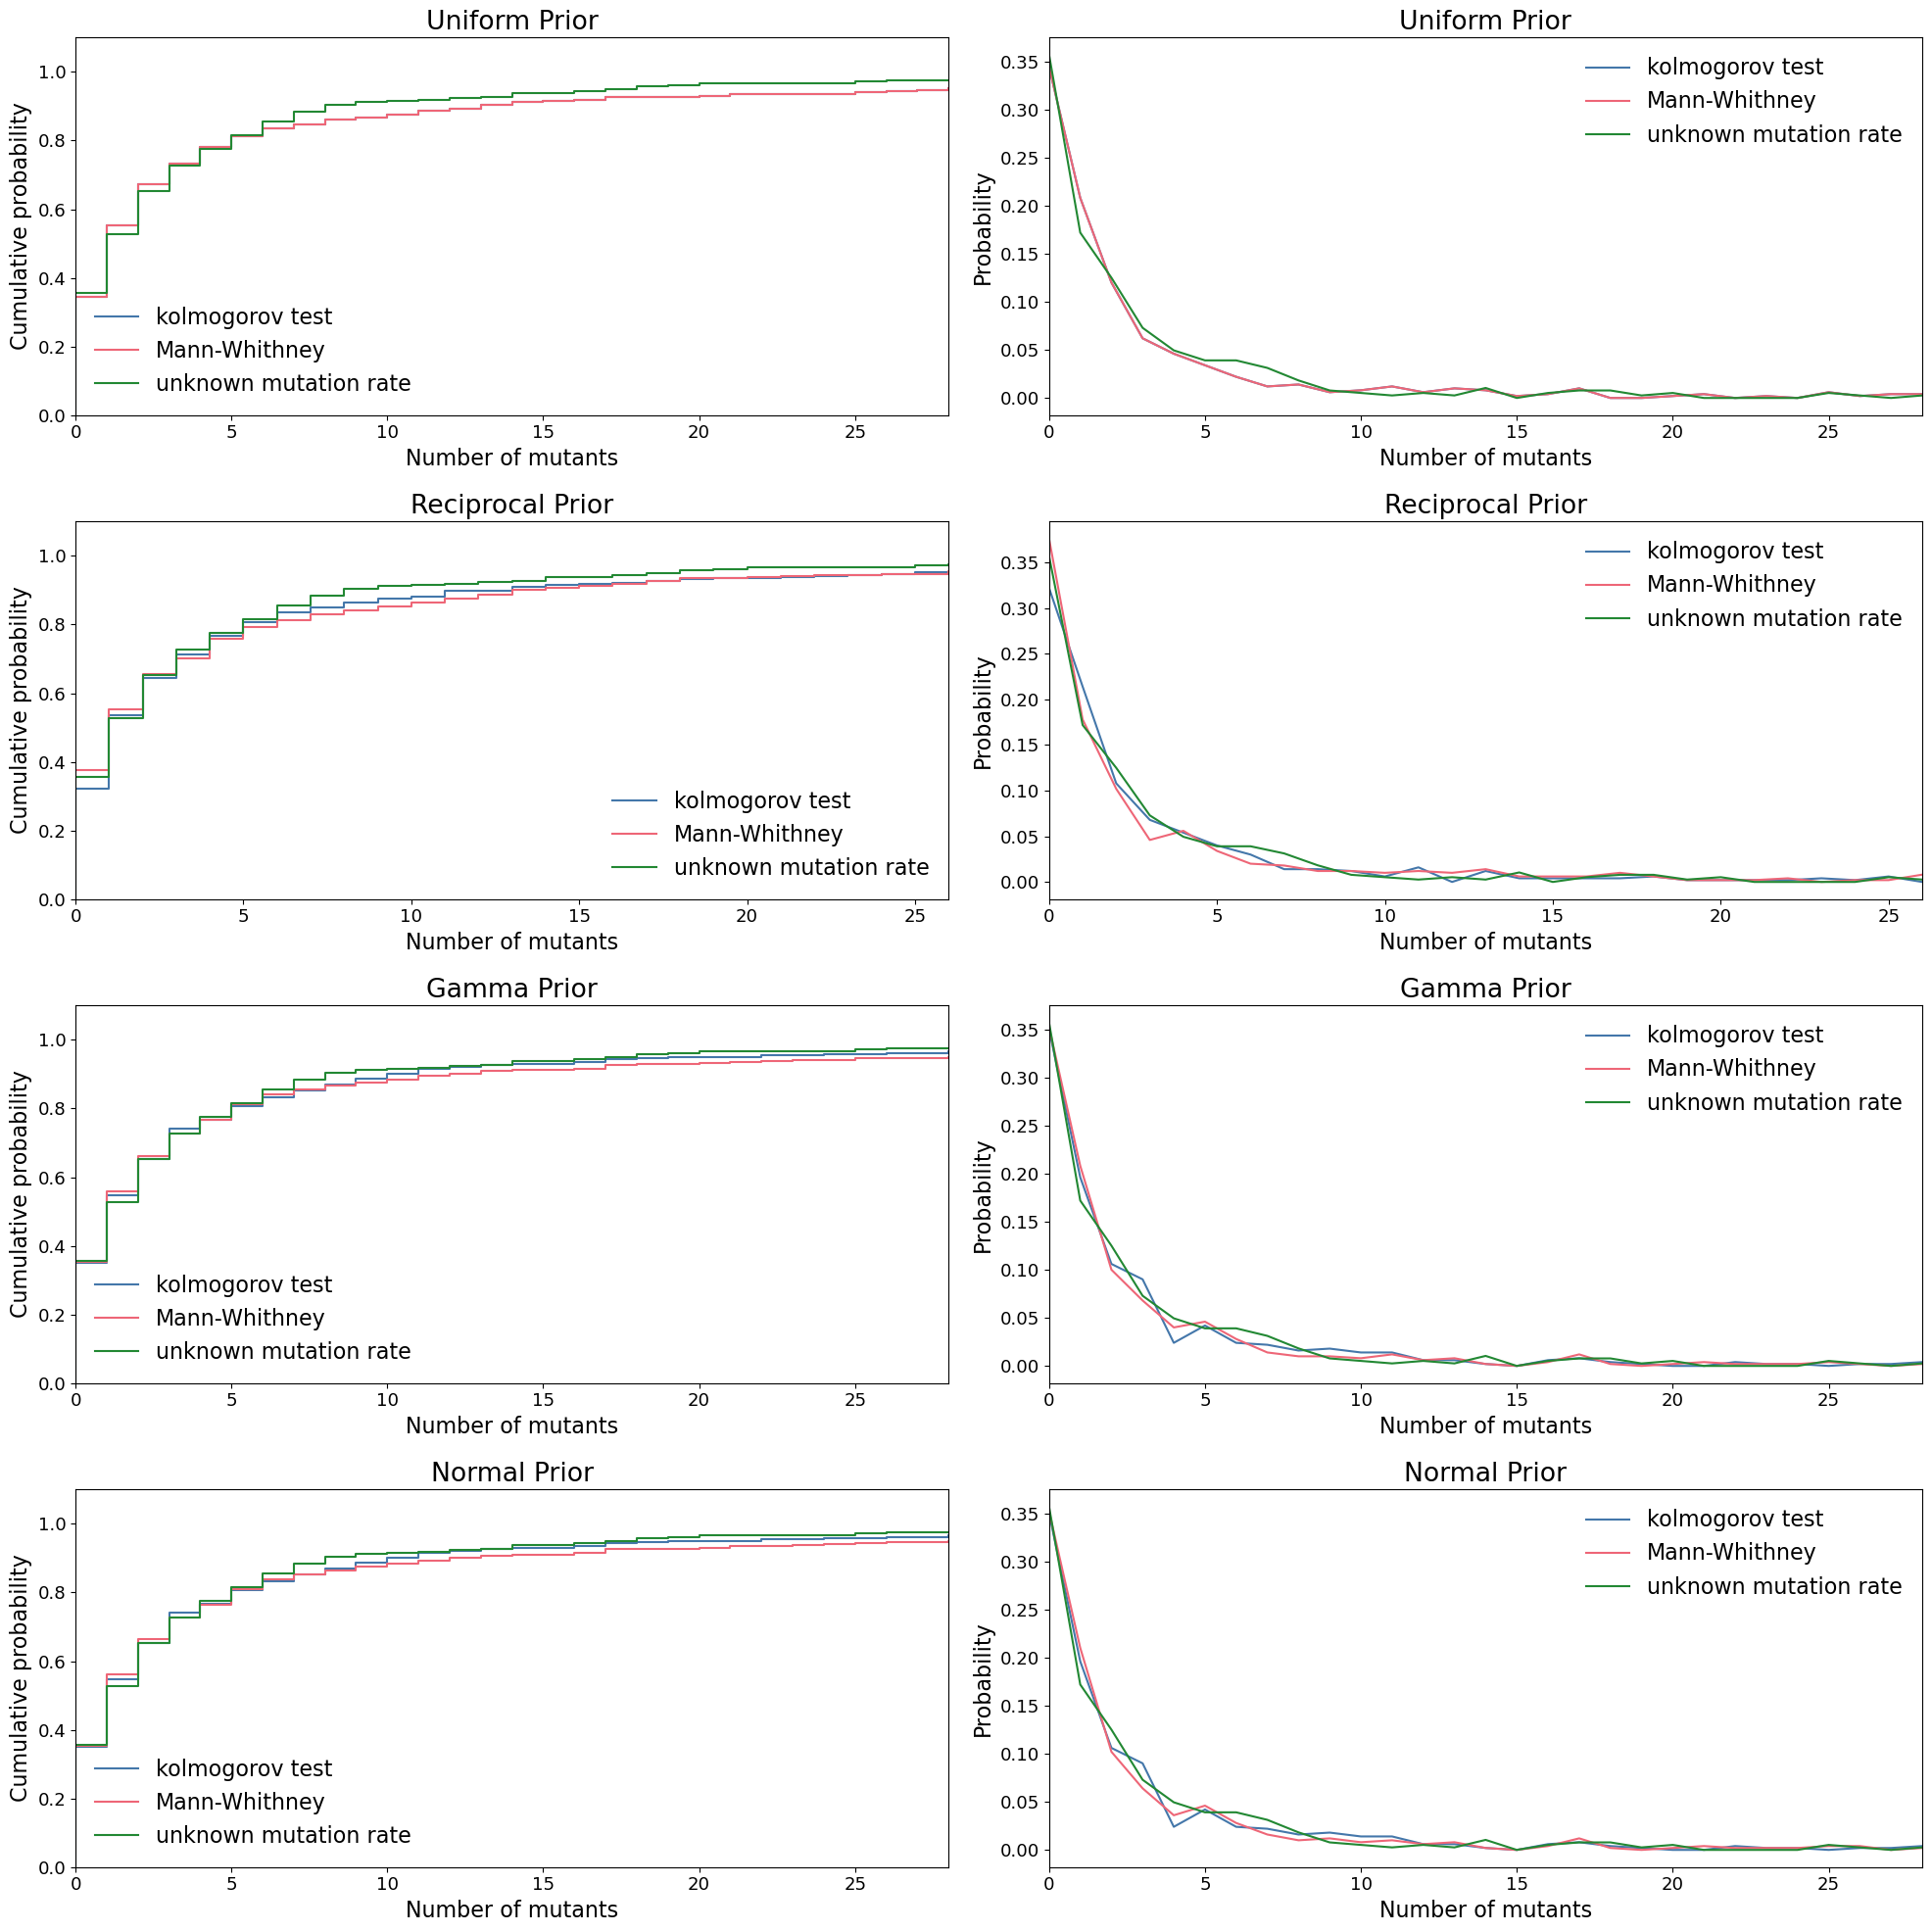

In [103]:
# Comparing using CDF and PDF 

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# Uniform prior
plot_cdf(distribution_kst_uniform,distribution_mwt_uniform,observed_data, ax=axes[0][0])
plot_pdf(distribution_kst_uniform,distribution_mwt_uniform,observed_data, ax=axes[0][1])
axes[0][0].set_title("Uniform Prior")
axes[0][1].set_title("Uniform Prior")

# Reciprocal prior
plot_cdf(distribution_kst_reciprocal,distribution_mwt_reciprocal,observed_data, ax=axes[1][0])
plot_pdf(distribution_kst_reciprocal,distribution_mwt_reciprocal,observed_data, ax=axes[1][1])
axes[1][0].set_title("Reciprocal Prior")
axes[1][1].set_title("Reciprocal Prior")

plot_cdf(distribution_kst_gamma,distribution_mwt_gamma,observed_data, ax=axes[2][0])
plot_pdf(distribution_kst_gamma,distribution_mwt_gamma,observed_data, ax=axes[2][1])
axes[2][0].set_title("Gamma Prior")
axes[2][1].set_title("Gamma Prior")

plot_cdf(distribution_kst_normal,distribution_mwt_normal,observed_data, ax=axes[3][0])
plot_pdf(distribution_kst_normal,distribution_mwt_normal,observed_data, ax=axes[3][1])
axes[3][0].set_title("Normal Prior")
axes[3][1].set_title("Normal Prior")


# Show the figure
plt.show()


### Interpretation

We can see that all of our priors seem to provide a value of $\mu$ that is sufficiently close to the real value, the real value being $\mu = 9 x 10^{-8}$. The Gamma prior performs slightly better as it is a conjugate prior for a Poisson posterior... But we are not supposed to know that!


Let's challenge our priors a little bit more, first by studying how the number of simulations run will affect the viability of the prior, second, by seeing how our priors respond to "less likely" values of mutation rates.

### Number of simulations

We will run the simulation the following number of times : $[10, 20, 50, 100, 200, 300]$ and will compare how
different priors perform.

In [113]:
# Setting up values needed to simulate and plot
n_mu_values = [10, 20, 50, 100, 150, 250, 300, 350, 400, 450, 500]
# We store the chosen values and the acceptance
# rates in order to compare the performance
# of the different priors
mu_mwt_uniform_values = []
acceptance_rates_uniform = []

mu_mwt_reciprocal_values = []
acceptance_rates_reciprocal = []

mu_mwt_gamma_values = []
acceptance_rates_gamma = []

mu_mwt_normal_values = []
acceptance_rates_normal = []

mu_kst_uniform_values = []
acceptance_rates_uniform_kst = []

mu_kst_reciprocal_values = []
acceptance_rates_reciprocal_kst = []

mu_kst_gamma_values = []
acceptance_rates_gamma_kst = []

mu_kst_normal_values = []
acceptance_rates_normal_kst = []

for n_mu in n_mu_values:
    # Setting up prior distributions
    mu_values_uniform = np.random.uniform(1e-8, 1e-6, size=n_mu)
    mu_values_reciprocal = scp.loguniform.rvs(1e-8, 1e-6, size=n_mu)
    mu_values_gamma = np.random.gamma(alpha, beta, size = n_mu)
    log_mu_values = np.random.normal(-16, 1, size=n_mu)
    mu_values_normal = np.exp(log_mu_values)
    
    # Simulating
    generated_df_uniform = simulate(mu_values_uniform, n_initial,n_final,death_rate,fitness,param,n_sample)
    generated_df_reciprocal = simulate(mu_values_reciprocal, n_initial,n_final,death_rate,fitness,param,n_sample)
    generated_df_gamma = simulate(mu_values_gamma, n_initial,n_final,death_rate,fitness,param,n_sample)
    generated_df_normal = simulate(mu_values_normal, n_initial,n_final,death_rate,fitness,param,n_sample)
    
    # Mann-Whiteney test
    mu_mwt_uniform, p_value_mwt_uniform = mann_whiteney_test(generated_df_uniform,observed_data)
    mu_mwt_reciprocal, p_value_mwt_reciprocal = mann_whiteney_test(generated_df_reciprocal,observed_data)
    mu_mwt_gamma, p_value_mwt_gamma = mann_whiteney_test(generated_df_gamma,observed_data)
    mu_mwt_normal, p_value_mwt_normal = mann_whiteney_test(generated_df_normal,observed_data)
    
    # Kolmogorov-Smirnov test
    mu_kst_uniform, p_value_kst_uniform = kolm_smirnov_test(generated_df_uniform,observed_data)
    mu_kst_reciprocal, p_value_kst_reciprocal = kolm_smirnov_test(generated_df_reciprocal,observed_data)
    mu_kst_gamma, p_value_kst_gamma = kolm_smirnov_test(generated_df_gamma,observed_data)
    mu_kst_normal, p_value_kst_normal = kolm_smirnov_test(generated_df_normal,observed_data)
    
    # Appending results to plot curve
    mu_mwt_uniform_values.append(mu_mwt_uniform.idxmax())
    mu_mwt_reciprocal_values.append(mu_mwt_reciprocal.idxmax())
    mu_mwt_gamma_values.append(mu_mwt_gamma.idxmax())
    mu_mwt_normal_values.append(mu_mwt_normal.idxmax())
    
    mu_kst_uniform_values.append(mu_mwt_uniform.idxmax())
    mu_kst_reciprocal_values.append(mu_mwt_reciprocal.idxmax())
    mu_kst_gamma_values.append(mu_mwt_gamma.idxmax())
    mu_kst_normal_values.append(mu_mwt_normal.idxmax())
    
    # Appending acceptance rates
    acceptance_rates_uniform.append(len(mu_mwt_uniform) / n_mu)
    acceptance_rates_reciprocal.append(len(mu_mwt_reciprocal) / n_mu)
    acceptance_rates_gamma.append(len(mu_mwt_gamma) / n_mu)
    acceptance_rates_normal.append(len(mu_mwt_normal) / n_mu)
    
    acceptance_rates_uniform_kst.append(len(mu_kst_uniform) / n_mu)
    acceptance_rates_reciprocal_kst.append(len(mu_kst_reciprocal) / n_mu)
    acceptance_rates_gamma_kst.append(len(mu_kst_gamma) / n_mu)
    acceptance_rates_normal_kst.append(len(mu_kst_normal) / n_mu)
    
# TO DO : Fix warning and error when no values are accepted

/tmp/ipykernel_3839/1348983463.py:57: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mu_mwt_uniform_values.append(mu_mwt_uniform.idxmax())
/tmp/ipykernel_3839/1348983463.py:60: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mu_mwt_normal_values.append(mu_mwt_normal.idxmax())
/tmp/ipykernel_3839/1348983463.py:62: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mu_kst_uniform_values.append(mu_mwt_uniform.idxmax())
/tmp/ipykernel_3839/1348983463.py:65: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mu_kst_normal_values.append(mu_mwt_n

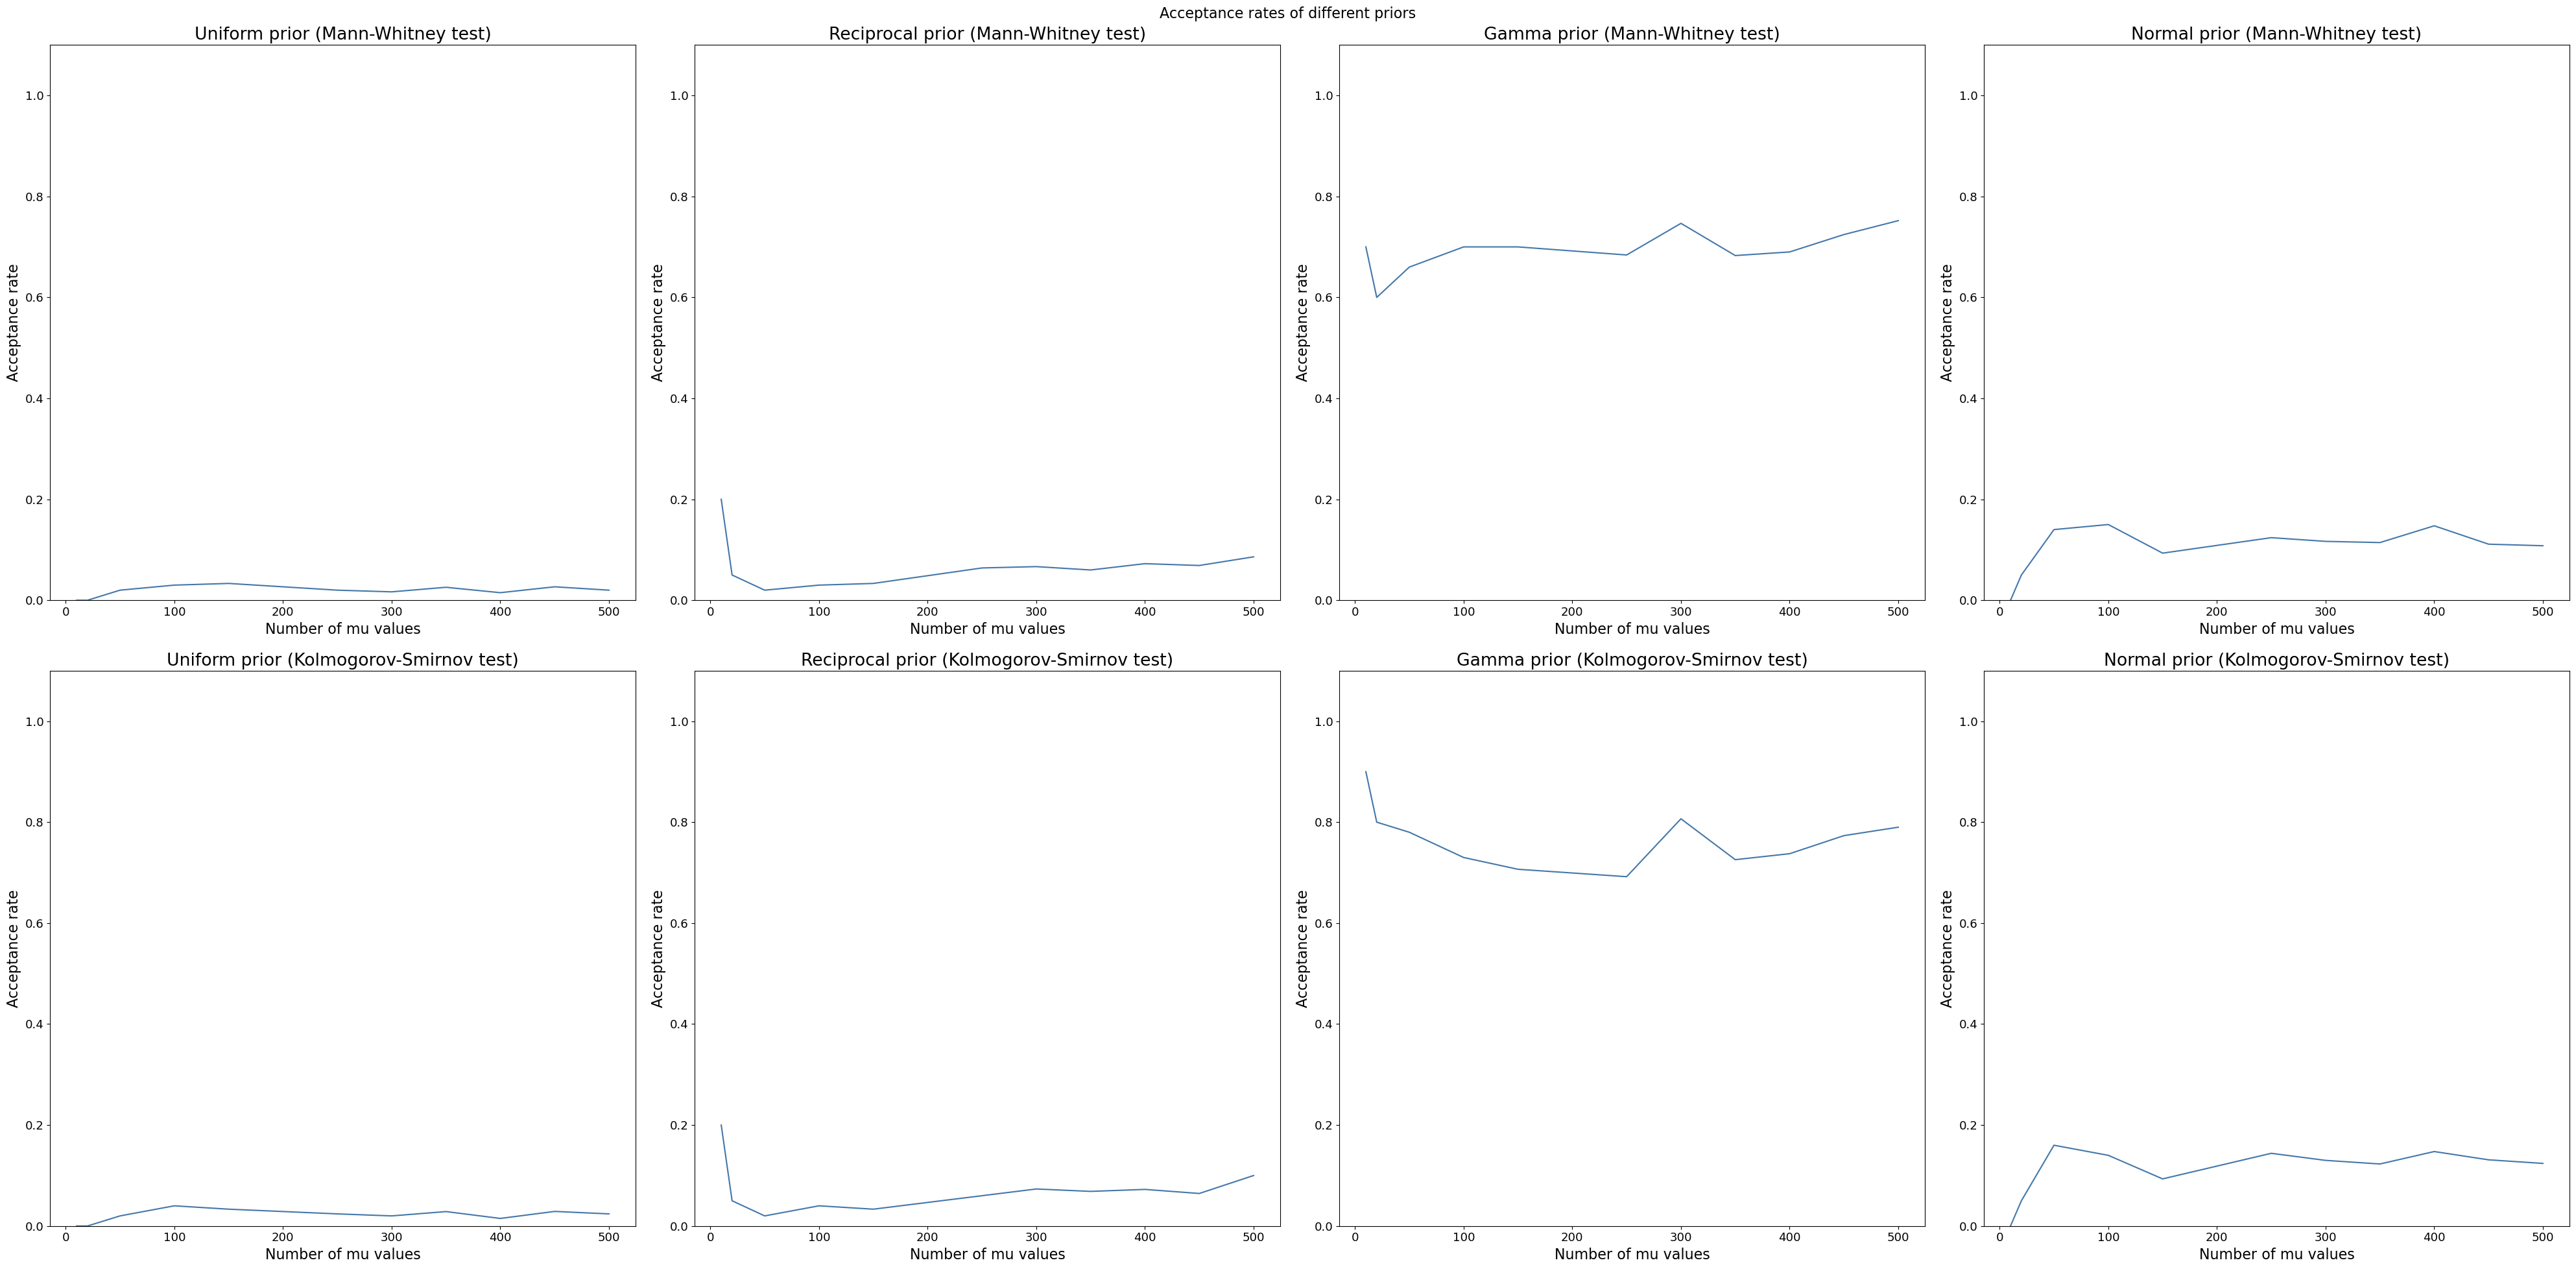

In [105]:
# Plotting acceptance rates
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(40, 20))

axs[0, 0].plot(n_mu_values, acceptance_rates_uniform)
axs[0, 0].set_title('Uniform prior (Mann-Whitney test)')
axs[0, 0].set_xlabel('Number of mu values')
axs[0, 0].set_ylabel('Acceptance rate')
axs[0, 0].set_ylim([0, 1.1])

axs[0, 1].plot(n_mu_values, acceptance_rates_reciprocal)
axs[0, 1].set_title('Reciprocal prior (Mann-Whitney test)')
axs[0, 1].set_xlabel('Number of mu values')
axs[0, 1].set_ylabel('Acceptance rate')
axs[0, 1].set_ylim([0, 1.1])

axs[0, 2].plot(n_mu_values, acceptance_rates_gamma)
axs[0, 2].set_title('Gamma prior (Mann-Whitney test)')
axs[0, 2].set_xlabel('Number of mu values')
axs[0, 2].set_ylabel('Acceptance rate')
axs[0, 2].set_ylim([0, 1.1])

axs[0, 3].plot(n_mu_values, acceptance_rates_normal)
axs[0, 3].set_title('Normal prior (Mann-Whitney test)')
axs[0, 3].set_xlabel('Number of mu values')
axs[0, 3].set_ylabel('Acceptance rate')
axs[0, 3].set_ylim([0, 1.1])

axs[1, 0].plot(n_mu_values, acceptance_rates_uniform_kst)
axs[1, 0].set_title('Uniform prior (Kolmogorov-Smirnov test)')
axs[1, 0].set_xlabel('Number of mu values')
axs[1, 0].set_ylabel('Acceptance rate')
axs[1, 0].set_ylim([0, 1.1])

axs[1, 1].plot(n_mu_values, acceptance_rates_reciprocal_kst)
axs[1, 1].set_title('Reciprocal prior (Kolmogorov-Smirnov test)')
axs[1, 1].set_xlabel('Number of mu values')
axs[1, 1].set_ylabel('Acceptance rate')
axs[1, 1].set_ylim([0, 1.1])

axs[1, 2].plot(n_mu_values, acceptance_rates_gamma_kst)
axs[1, 2].set_title('Gamma prior (Kolmogorov-Smirnov test)')
axs[1, 2].set_xlabel('Number of mu values')
axs[1, 2].set_ylabel('Acceptance rate')
axs[1, 2].set_ylim([0, 1.1])

axs[1, 3].plot(n_mu_values, acceptance_rates_normal_kst)
axs[1, 3].set_title('Normal prior (Kolmogorov-Smirnov test)')
axs[1, 3].set_xlabel('Number of mu values')
axs[1, 3].set_ylabel('Acceptance rate')
axs[1, 3].set_ylim([0, 1.1])

plt.suptitle('Acceptance rates of different priors', fontsize=16)
plt.tight_layout()
plt.show()

### Interpretation

We can see that the acceptance rate for the Gamma prior is much higher than that of the other priors, making it the best suited prior to use for the sake of our simulation. Having a high acceptance rate means being able to simulate approached values of $\mu$ without having to run the simulation many times, which, in this context, is very useful.

We can also see that the two tests we used generally give the same acceptance rate, which means that their results will not vary greatly.

Let's now compare the accepted value and its evolution through the number of simulated values of $\mu$.


##### Using mean of Results :

The choice of $\mu$ can be done in another way :
- Using the  Mann–Whitney U test or Kolmogorov–Smirnov test we choose the mean of all values with p-value > 0.05 and then simulate a sample using it, then do same vizualisation bellow.

#### -  Mann–Whitney U test

In [106]:
mu_mwt_mean = mann_whiteney_test_mean(generated_df_gamma,observed_data)
print("The best value of mutation rate using Mann–Whitney U test mean is " + str(np.mean(mu_mwt_mean)))

The best value of mutation rate using Mann–Whitney U test mean is 8.749682255448773e-08


##### - Kolmogorov–Smirnov test

In [107]:
mu_kst_mean = kolm_smirnov_test_mean(generated_df_gamma,observed_data)
print("The best value of mutation rate using kolmogorov-Smirnov test mean is " + str(np.mean(mu_kst_mean)))
pd.DataFrame()

The best value of mutation rate using kolmogorov-Smirnov test mean is 8.797132767880567e-08


""


#####  Sampling and validation 

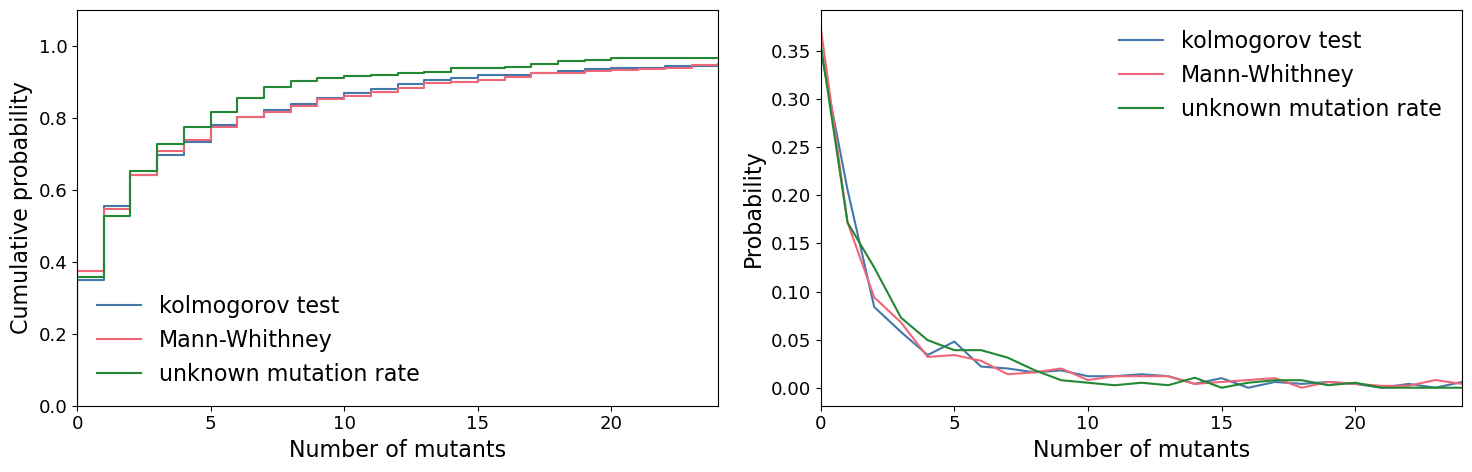

In [108]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
generated_df2 = simulate([np.mean(mu_kst_mean),np.mean(mu_mwt_mean)],n_initial,n_final,death_rate,fitness,param,n_sample)
distribution_kst_mean = generated_df2[np.mean(mu_kst_mean)]
distribution_mwt_mean = generated_df2[np.mean(mu_mwt_mean)]
plot_cdf(distribution_kst_mean,distribution_mwt_mean,observed_data, ax=axes[0])
plot_pdf(distribution_kst_mean,distribution_mwt_mean,observed_data, ax=axes[1])

#### Conclusion : 
Using the kolmogorov-Smirnov test and Mann–Whitney U test we can conclude that a value of real mutation rate is $\mu_{real} \approx 8.8x10^{-8}$.

## Rejection Algorithm : Conclusion

 We can see that the rejection algorithm we used gives a good estimation of the real parameter $\mu = 9x10^{-9}$. For our simplified model, we can conclude that using a rejection algorithm is enough. However, when we deal with multidimensional parameters, using a rejection algorithm can prove unsufficient. Furthermore, our algorithm is heavily dependent on acceptance rates and the number of simulations, and require a sufficiently high number simulations to be able to provide consistent results, which is costly in terms of computational ressources.
 
 We will now explore now another class of ABC techniques, namely, MCMC methods which rely on iteritavely updating the prior by using the results of the current simulation.

## MCMC methods

### Introduction

MCMC methods are a type of computational algorithm used for simulating complex systems. These algorithms involve constructing a Markov chain in which each state in the chain is a sample from a probability distribution of interest. The Markov chain is constructed such that the distribution of states converges to the target distribution over time. MCMC methods have a wide range of applications, such as in Bayesian statistics, physics, and machine learning, and have enabled the solution of many previously intractable problems.

### Metropolis-Hastings

The Metropolis-Hastings algorithm is a sampling algorithm that allows us to generate a Markov chain such that its initial distribution is the target distribution of interest. It is particularly useful for sampling from a distribution $\pi(\mu)$ when the normalization constant of this distribution is intractable. In a Bayesian context, this algorithm is often used to sample from the posterior distribution.

The algorithm is built on a rejection algorithm. For a given state $\mu^t$, the algorithm specifies, based on an instrumental transition kernel $q(\mu^t, \mu^*)$, how to generate the next state $\mu^{t+1}$, either by accepting the proposed candidate point, in which case $\mu^{t+1} = \mu^{*}$, or by rejecting it, in which case $\mu^{t+1} = \mu^t$.

The algorithm can be summarized as follows:

1. Initialize $\mu^{t}$ and $y^t$.
2. Propose $\mu^{*} \sim q(\mu^{*}|\mu^{t})$.
3. Generate $y^{*}$ conditionally on $\mu^{*}$ and compute $I_{y}(y^{*})$.
4. If $I_{y}(y^{*}) = 1$, go to step 5, otherwise stay at $\mu^{t}$ and return to step 2.
5. Calculate acceptance probability $\alpha = \min \left(1, \frac{\pi(\mu^{*})q(\mu^{t}|\mu^{*})}{\pi(\mu^{t})q(\mu^{*}|\mu^{t})} \right)$.
6. Generate $u \sim U(0,1)$. If $u < \alpha$, set $\mu^{t} = \mu^{*}$, otherwise stay at $\mu^{t}$.
7. Return to step 2.

Source : https://www.maths.lu.se/fileadmin/maths/forskning_research/InferPartObsProcess/abc_slides.pdf page 36


In [380]:
## We use a Gamma prior as we have shown that is the best fit
# Generate samples from the Gamma distribution
alpha = 81
beta = 1.11e-9
mu_0 = scp.uniform.rvs(1e-11,1e-6)
option = 1
kernel_name = "exponential"

In [400]:
"""Transition kernel is separately defined
    in a function so it is easy to redefine"""
def transition_kernel_rvs(mu_1):
    mu = 0
    while (mu < 1e-9) or (mu > 1e-5):
        if kernel_name == "uniform":
            mu = np.random.uniform(mu_1 - mu_1/10, mu_1 + mu_1/10)
        if kernel_name == "gamma":
            mu = np.random.gamma(3, mu_1/3)
        if kernel_name == "normal":
            mu = np.random.normal(mu_1, 5e-9)
        if kernel_name == "exponential":
            mu = np.random.exponential(mu_1,1)
    return mu

def transition_kernel_pdf(mu_1, mu_2):
    if kernel_name == "uniform":
        x = mu_1 - mu_1/10
        y = mu_1 + mu_1/10
        return scp.uniform.pdf(mu_2, loc=x, scale=y-x)
    elif kernel_name == "gamma":
        shape = 3
        scale = mu_2/shape
        return scp.gamma.pdf(mu_1, shape, scale)
    elif kernel_name == "normal":
        return scp.norm.pdf(mu_2, loc=mu_1, scale=5e-9)
    elif kernel_name == "exponential":
        return scp.expon.pdf(mu_2, scale=1/mu_1)

"""Prior is separately defined in a function so it
    is easier to redefine"""
def prior(mu, prior_type, observed_data):
    p = 0
    steps = 0
    while (p < 1e-9) or (p > 1e-5):
        epsilon = 1e-9
        steps += 1
        if prior_type == "uniform":
            p = np.random.uniform(1e-9, 1e-5, size=1)
        if prior_type == "reciprocal":
            p = scp.loguniform.rvs(1e-9, 1e-5, size=1)
        if prior_type == "gamma":
            alpha = (np.median(observed_data / n_final) + epsilon)**2 / (scp.iqr(observed_data / n_final)**2 + 1e-18)
            beta = (np.median(observed_data / n_final) + epsilon) / (scp.iqr(observed_data / n_final)**2 + 1e-18)
            p = np.random.gamma(alpha, 1/beta, size = 1) - epsilon
        if prior_type == "normal":
            p = np.exp(np.random.normal(np.median(np.log((observed_data + 0.01) / n_final)), np.sqrt(np.log(scp.gstd((observed_data + 0.01)/ n_final)**2 + 1)), size = 1))
        if prior_type == "exponential":
            p = np.random.exponential(np.median(observed_data)/n_final + epsilon , size = 1) - epsilon
        if steps > 1000:
            return scp.loguniform.rvs(1e-9, 1e-5, size=1)
    return p


    
"""Metropolis-Hastings impelementation in Python
    Given a prior and a sample, uses Metropolis_Hastings
    sampling to sample from an updated version of the prior
    p : Number of simulations """
def metropolis_hastings(p, mu_prior, prior_type, observed_data, n_initial, n_final, death_rate, fitness, param, n_sample, error, burn_in):
    current_mu = np.array([mu_prior])
    mu_values = [current_mu]
    proposed_values = [current_mu] # <- Used to compare accepted values to all values
    accepted_values = [] # Used to avoid duplication of accepted values
    accepted = 1 # Used to calculate acceptance rate
    previous_y = simulate(current_mu, n_initial, n_final, death_rate, fitness, param, n_sample)
    
    for i in range(p):
        # We generate a candidate mu from which we generate a distribution y
        proposed_mu = transition_kernel_rvs(current_mu)
        proposed_values.append(proposed_mu)
        proposed_y = simulate(proposed_mu, n_initial, n_final, death_rate, fitness, param, n_sample)
        
        p_values = proposed_y.apply(lambda x: scp.kstest(x, observed_data)[1])
        previous_p_values = previous_y.apply(lambda x: scp.kstest(x, observed_data)[1])
        if option == 1:
            Iy_star = (p_values.values/previous_p_values.values > 0.7).all()  # Checking if generated y is consistent with observed data
            
        if option == 2:
            Iy_star = (p_values > error).all()  # Checking if generated y is consistent with observed data
        
        if Iy_star:
            
            # If it is consistent, we calculate MH ratios
            a  = prior(current_mu, prior_type, observed_data)
            # in case prior a equal to zero we accept the current_mu 
            if a == 0:
                alpha = 1
            else:
                r1 = prior(proposed_mu,prior_type, observed_data) / a
                r2 = transition_kernel_pdf(current_mu,proposed_mu) / transition_kernel_pdf(proposed_mu,current_mu)
                alpha = min(1, r1 * r2)

            # Accept or reject proposal
            u = np.random.uniform(0, 1)
            if u <= alpha:
                current_mu = proposed_mu
                previous_y = proposed_y
                if (i > burn_in):
                    accepted_values.append(current_mu)
                    accepted += 1

            
            mu_values.append(current_mu)
                
        else:
            
            # If generated data is not consisted with observed data, we reject the candidate
            mu_values.append(current_mu)
            

    return mu_values[burn_in:], accepted_values[1:], accepted/p, proposed_values

In [396]:
n_sample = 350
real_mu = 9e-8
mu_values_gamma, accepted_values_gamma, accepted_rate_gamma, proposed_values_gamma = metropolis_hastings(10000, mu_0 ,"gamma", observed_data, n_initial, n_final, death_rate, fitness, param, n_sample, 0.0005, 200)
mu_values_uniform, accepted_values_uniform, accepted_rate_uniform, proposed_values_uniform = metropolis_hastings(10000, mu_0 ,"uniform", observed_data, n_initial, n_final, death_rate, fitness, param, n_sample, 0.0005, 200)

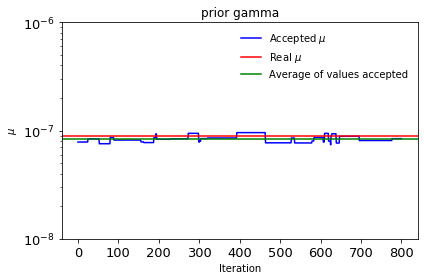

the mean value of mutation rate values accepted by gamma prior 8.379275512972397e-08


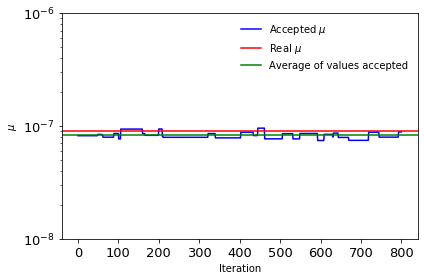

the mean value of mutation rate values accepted by uniform prior 8.340947755126625e-08


In [397]:
# Plot accepted mu values
plt.semilogy(mu_values_gamma, 'b', label='Accepted $\mu$')
plt.ylim([1e-8, 1e-6])
plt.xlabel('Iteration')
plt.ylabel('$\mu$')
# Plotting real value of mu
plt.axhline(y=real_mu, color='r', linestyle='-', label='Real $\mu$')
# Plotting average of values accepted
plt.axhline(y=np.mean(accepted_values_gamma), color='g', linestyle='-', label='Average of values accepted')
plt.title("prior gamma")
plt.legend()
plt.show()

print("the mean value of mutation rate values accepted by gamma prior",np.mean(accepted_values_gamma))


# Plot accepted mu values
plt.semilogy(mu_values_uniform, 'b', label='Accepted $\mu$')
plt.ylim([1e-8, 1e-6])
plt.xlabel('Iteration')
plt.ylabel('$\mu$')
# Plotting real value of mu
plt.axhline(y=real_mu, color='r', linestyle='-', label='Real $\mu$')
# Plotting average of values accepted
plt.axhline(y=np.mean(accepted_values_uniform), color='g', linestyle='-', label='Average of values accepted')
plt.legend()
plt.show()
print("the mean value of mutation rate values accepted by uniform prior",np.mean(accepted_values_uniform))

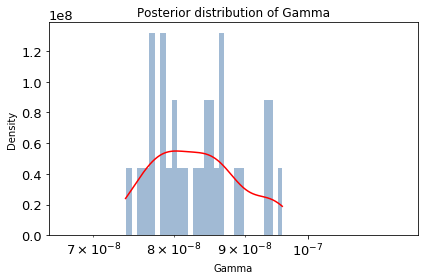

In [398]:
accepted_values_gamma = [x.item() for x in accepted_values_gamma]


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a histogram of the posterior distribution
ax.hist(accepted_values_gamma, bins=30, density=True, alpha=0.5)

# Plot a kernel density estimate of the posterior distribution
kde = scp.gaussian_kde(accepted_values_gamma)
x = np.linspace(min(accepted_values_gamma), max(accepted_values_gamma), 10000)
ax.plot(x, kde(x), color='red')

# Set the x-axis to logarithmic scale
ax.set_xscale('log')

# Set the x-axis limits to the desired range
ax.set_xlim([6.5e-8, 1.2e-7])

# Add labels and a title to the plot
ax.set_xlabel('Gamma')
ax.set_ylabel('Density')
ax.set_title('Posterior distribution of Gamma')

# Show the plot
plt.show()

With Exponential transition kernel, we notice that metropolis algorithm with gamma prior converges faster to the real value of mu than uniform prior.

## First parameter : Acceptance rate

We will first try to see how our our different transition kernels affect and our acceptance criterium affect our acceptance rate. We will then explore how, in turn, this acceptance rate affect the precision of our algorithm.

In general, an ideal acceptance rate in an MCMC algorithm is around 20-50%. This range is considered optimal because it ensures that the algorithm explores the parameter space efficiently, without getting stuck in one particular region. If the acceptance rate is too low, the algorithm will take a long time to explore the parameter space, while if the acceptance rate is too high, the algorithm may get stuck in a particular region of the parameter space and fail to explore other regions.


### Different Priors

We fix the value of error in our MCMC function with 0.00005 and our burn_in variable to 150.
Let us go through the different priors and compare the acceptance values they result in.


To do this, we are going to choose a value that we calculate using the median of given data :

$$ \tilde{\mu} = \frac{\tilde x_n}{n_{final}} $$

We will be using different priors to generate our values of $\mu$, and will be comparing their results. The followings priors will be used :

-A uniform distribution such that: $$\mu \sim \mathcal{U}(10^{-9}, 10^{-5})$$

-A reciprocal distribution such that: $$log(\mu) \sim \mathcal{U}(log(10^{-9}), log(10^{-5}))$$

-A gamma distribution such that: $$\mu \sim \gamma(\alpha, \beta)$$

-A log-normal distribution such that: $$log(\mu) \sim \mathcal{N}(log(10^{-7}), 0.5)$$

such that : $\alpha = \frac{\tilde{x}^{2}}{IQR^2}$ and $\beta = \frac{\tilde{x}}{IQR^2}$ with $\tilde{x}$ the median of $x$ and $IQR$ its interquantile range.


We redefine our prior function.

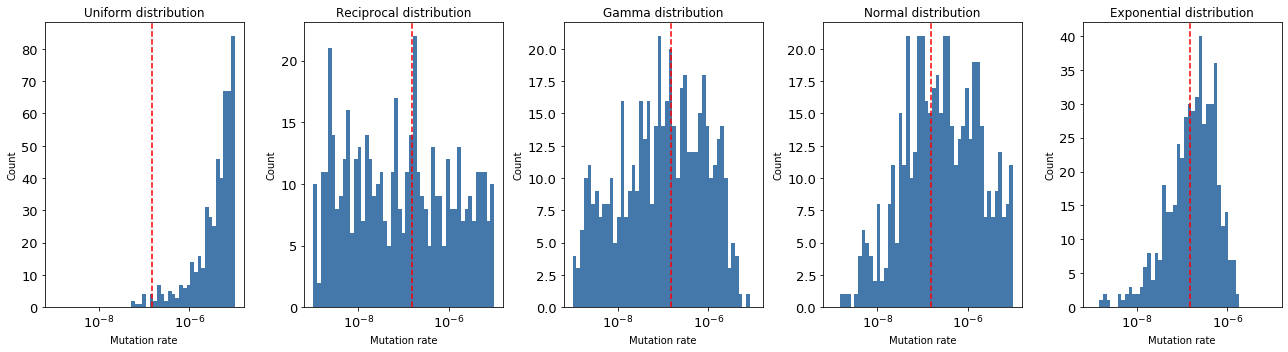

In [401]:
random_mu = scp.loguniform.rvs(1e-9, 1e-5)
observed_data = simulate_observed_data(random_mu, n_initial, n_final, death_rate, fitness, param, 10000)

uniform_prior = []
reciprocal_prior = []
gamma_prior = []
normal_prior = []
exponential_prior = []

for i in range(500):
    uniform_prior.append(prior(random_mu, 'uniform', observed_data).item())
    
for i in range(500):
    reciprocal_prior.append(prior(random_mu, 'reciprocal', observed_data).item())
    
for i in range(500):
    gamma_prior.append(prior(random_mu, 'gamma', observed_data).item())
    
for i in range(500):
    normal_prior.append(prior(random_mu, 'normal', observed_data).item())
    
for i in range(500):
    exponential_prior.append(prior(random_mu, 'exponential', observed_data).item())
    
    
# Define the bins for the histograms
bins = np.logspace(start=-9, stop=-5, num=50)

# Plot the histograms side by side
fig, axs = plt.subplots(1, 5, figsize=(18, 5))

axs[0].hist(uniform_prior, bins=bins)
axs[0].set_xscale('log')
axs[0].set_xlabel('Mutation rate')
axs[0].set_ylabel('Count')
axs[0].set_title('Uniform distribution')

axs[1].hist(reciprocal_prior, bins=bins)
axs[1].set_xscale('log')
axs[1].set_xlabel('Mutation rate')
axs[1].set_ylabel('Count')
axs[1].set_title('Reciprocal distribution')

axs[2].hist(gamma_prior, bins=bins)
axs[2].set_xscale('log')
axs[2].set_xlabel('Mutation rate')
axs[2].set_ylabel('Count')
axs[2].set_title('Gamma distribution')

axs[3].hist(normal_prior, bins=bins)
axs[3].set_xscale('log')
axs[3].set_xlabel('Mutation rate')
axs[3].set_ylabel('Count')
axs[3].set_title('Normal distribution')

axs[4].hist(exponential_prior, bins=bins)
axs[4].set_xscale('log')
axs[4].set_xlabel('Mutation rate')
axs[4].set_ylabel('Count')
axs[4].set_title('Exponential distribution')

for ax in axs:
    ax.axvline(random_mu, color='red', linestyle='--', label='random_mu')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.2)

# Show the plot
plt.show()

We then run the simulation with some arbitrary values of $mu$ to see how it affects the acceptance rate.

In [404]:
mu_values = scp.loguniform.rvs(1e-9, 1e-5, size = 20)
priors = ["uniform", "reciprocal", "gamma", "normal", "exponential"]
k=0

acceptance_rates = []
p_errors = []
for prior_type in priors:
    prior_rates = []
    prior_errors = []
    for mu in mu_values:
        k+=1
        print(k)
        observed_data = simulate_observed_data(mu, n_initial, n_final, death_rate, fitness, param, 1000)
        mu_prior_values, accepted_values, acceptance_rate, proposed_values = metropolis_hastings(1000, mu ,prior_type, observed_data, n_initial, n_final, death_rate, fitness, param, n_sample, 0.00005, 150)
        prior_errors.append(abs(np.mean(accepted_values) - mu_value) / mu_value)
        prior_rates.append(acceptance_rate)
    acceptance_rates.append(prior_rates)
    p_errors.append(prior_errors)
    


1
2
3
4
5
6
7
8


KeyboardInterrupt: 

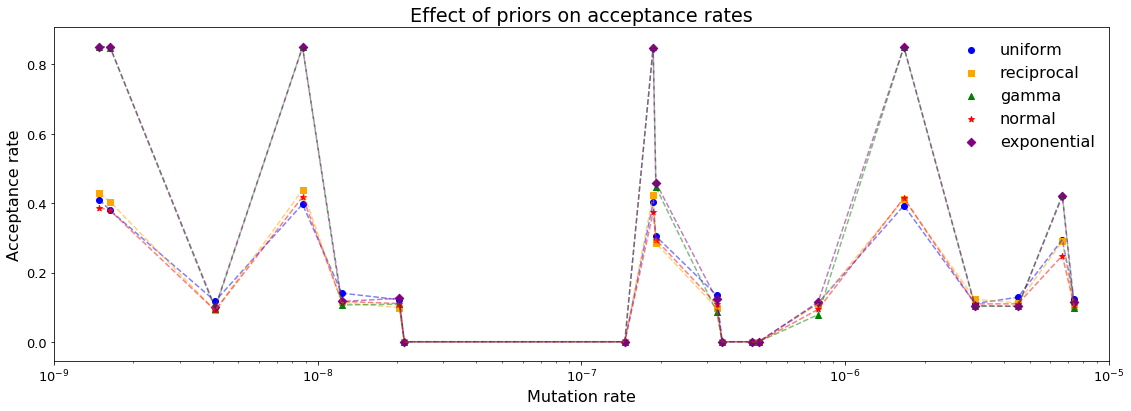

In [152]:
# Plot the data
mu_values = np.sort(mu_values)
colors = ["blue", "orange", "green", "red", "purple"]
markers = ["o", "s", "^", "*", "D"]
for i in range(len(priors)):
    plt.scatter(mu_values, acceptance_rates[i], label=priors[i], color=colors[i], marker=markers[i])

# Add a trendline to each set of data points
for i in range(len(priors)):
    plt.plot(mu_values, acceptance_rates[i], color=colors[i], alpha=0.5, linestyle='--')

# Add labels and legends
plt.xlabel("Mutation rate")
plt.ylabel("Acceptance rate")
plt.title("Effect of priors on acceptance rates")
plt.xscale('log')
plt.xlim([1e-9, 1e-5])
plt.legend()

# Show the plot
plt.show()

### Different Transition Kernels

Now that we have evaluated the impact of the priors on the acceptance rates and on the resulting error, we evaluate how those two metrics are influenced by the choice of the transition kernel. We use a gamma prior as it is the one that provides the most satisfying results.

Gaussian proposal: This kernel proposes new values of mutation rate by drawing from a Gaussian distribution centered on the current value of mu with a given standard deviation.

Lognormal proposal: This kernel proposes new values of mutation rate by drawing from a lognormal distribution centered on the log of the current value of mu with a given standard deviation.

Uniform proposal: This kernel proposes new values of mutation rate uniformly from a given range centered on the current value of mu.

Beta proposal: This kernel proposes new values of mutation rate by drawing from a beta distribution with shape parameters α and β centered on the current value of mu.

In [409]:
mu_values = scp.loguniform.rvs(1e-9, 1e-5, size = 20)
kernels = ["uniform", "gamma", "normal", "exponential"]
k_errors = []
k = 0

acceptance_rates = []
for kernel_name in kernels:
    kernel_rates = []
    kernel_errors = []
    for mu in mu_values:
        observed_data = simulate_observed_data(mu, n_initial, n_final, death_rate, fitness, param, 1000)
        mu_kernel_values, accepted_values, acceptance_rate, proposed_values = metropolis_hastings(100, mu , "exponential", observed_data, n_initial, n_final, death_rate, fitness, param, n_sample, 0.00005, 50)
        kernel_rates.append(acceptance_rate)
        kernel_errors.append(abs(np.mean(accepted_values) - mu_value) / mu_value)
    acceptance_rates.append(kernel_rates)
    k_errors.append(kernel_errors)

/tmp/ipykernel_5988/235440280.py:91: RuntimeWarning: divide by zero encountered in divide
  r2 = transition_kernel_pdf(current_mu,proposed_mu) / transition_kernel_pdf(proposed_mu,current_mu)
/tmp/ipykernel_5988/235440280.py:91: RuntimeWarning: divide by zero encountered in divide
  r2 = transition_kernel_pdf(current_mu,proposed_mu) / transition_kernel_pdf(proposed_mu,current_mu)
/tmp/ipykernel_5988/235440280.py:91: RuntimeWarning: divide by zero encountered in divide
  r2 = transition_kernel_pdf(current_mu,proposed_mu) / transition_kernel_pdf(proposed_mu,current_mu)
/tmp/ipykernel_5988/235440280.py:91: RuntimeWarning: divide by zero encountered in divide
  r2 = transition_kernel_pdf(current_mu,proposed_mu) / transition_kernel_pdf(proposed_mu,current_mu)
/tmp/ipykernel_5988/235440280.py:91: RuntimeWarning: divide by zero encountered in divide
  r2 = transition_kernel_pdf(current_mu,proposed_mu) / transition_kernel_pdf(proposed_mu,current_mu)
/tmp/ipykernel_5988/235440280.py:91: RuntimeW

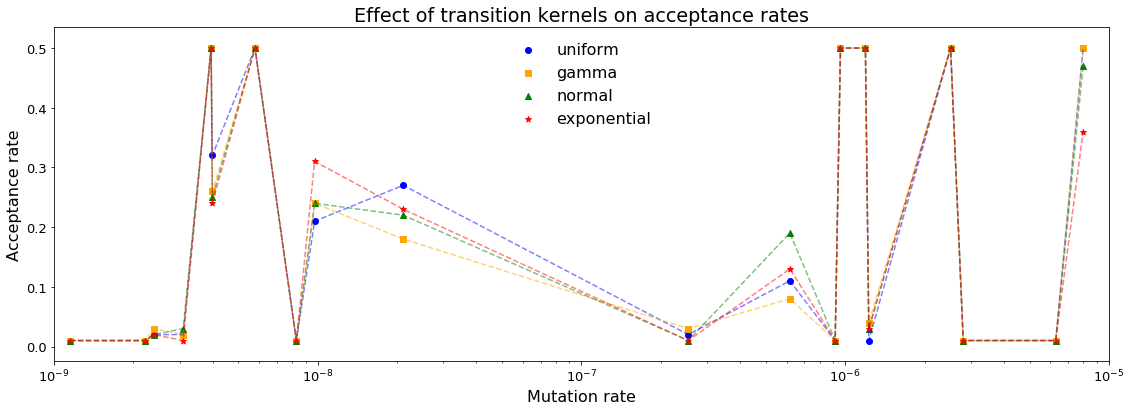

In [51]:
# Plot the data
mu_values = np.sort(mu_values)
colors = ["blue", "orange", "green", "red", "purple"]
markers = ["o", "s", "^", "*", "D"]
for i in range(len(kernels)):
    plt.scatter(mu_values, acceptance_rates[i], label=kernels[i], color=colors[i], marker=markers[i])

# Add a trendline to each set of data points
for i in range(len(kernels)):
    plt.plot(mu_values, acceptance_rates[i], color=colors[i], alpha=0.5, linestyle='--')

# Add labels and legends
plt.xlabel("Mutation rate")
plt.ylabel("Acceptance rate")
plt.title("Effect of transition kernels on acceptance rates")
plt.xscale('log')
plt.xlim([1e-9, 1e-5])
plt.legend()

# Show the plot
plt.show()

## Second parameter : Error

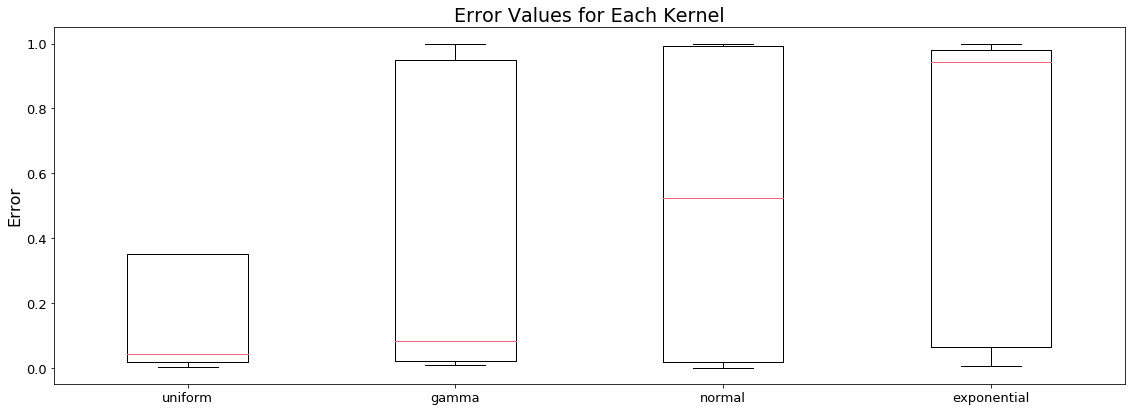

In [73]:
cleanedErrors = [[], [], [], []]
for i in range(len(errors)):
    cleanedErrors[i] = [1 if str(x) == 'nan' else x for x in k_errors[i]]


# plot the boxplot
plt.boxplot(cleanedErrors, labels=kernels, showmeans=False, meanline=False, showfliers=False)
plt.title('Error Values for Each Kernel')
plt.ylabel('Error')
plt.show()

## Acceptance Criterium

In [30]:
kernel_name = "gamma"
option = 1

errors = []
option_errors = []
for i in range(10):
    mu_value = scp.loguniform.rvs(1e-9, 1e-5, size = 1)[0]
    observed_data = simulate_observed_data(mu_value, n_initial, n_final, death_rate, fitness, param, 200)
    mu_kernel_values, accepted_values, acceptance_rate, proposed_values = metropolis_hastings(100, mu_value , "exponential", observed_data, n_initial, n_final, death_rate, fitness, param, n_sample, 0.00005, 10)
    option_errors.append(abs(np.mean(accepted_values) - mu_value) / mu_value)
errors.append(option_errors)

option = 2
option_errors = []
for i in range(10):
    mu_value = scp.loguniform.rvs(1e-9, 1e-5, size = 1)[0]
    observed_data = simulate_observed_data(mu_value, n_initial, n_final, death_rate, fitness, param, 200)
    mu_kernel_values, accepted_values, acceptance_rate, proposed_values = metropolis_hastings(100, mu_value , "exponential", observed_data, n_initial, n_final, death_rate, fitness, param, n_sample, 0.00005, 10)
    option_errors.append(abs(np.mean(accepted_values) - mu_value) / mu_value)
errors.append(option_errors)

0
1
2
3


/home/elbouanani/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/elbouanani/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4
5


/home/elbouanani/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/elbouanani/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6
7
8
9
0


/home/elbouanani/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/elbouanani/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1
2
3


/home/elbouanani/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/elbouanani/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4
5
6
7
8
9


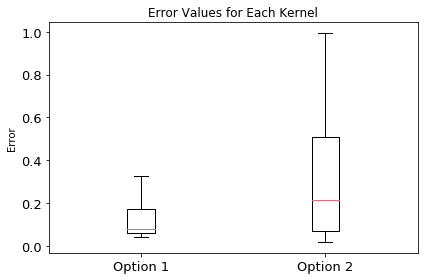

In [35]:
cleanedErrors = [[], []]
for i in range(len(errors)):
    cleanedErrors[i] = [1 if str(x) == 'nan' else x for x in errors[i]]

# plot the boxplot
plt.boxplot(cleanedErrors, labels=["Option 1", "Option 2"], showmeans=False, meanline=False, showfliers=False)
plt.title('Error Values for Each Option')
plt.ylabel('Error')
plt.show()